In [3]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read in the dataset
tournament_data = pd.read_csv("datasets/kaggle_data/TourneyCompactResults.csv")
teams = pd.read_csv("datasets/kaggle_data/Teams.csv")
seeds = pd.read_csv("datasets/kaggle_data/TourneySeeds.csv")
slots = pd.read_csv("datasets/kaggle_data/TourneySlots.csv")

In [5]:
# filtration function
def filter_season(data, season):
    return data[data["Season"] == season]
    
def filter_into_seasons(data):
    # buffer to hold list of seasons
    season_arr = []
    
    # min and max
    max_season = data["Season"].max()
    min_season = data["Season"].min()
    
    # filter
    for season in range(min_season, max_season + 1):
        season_arr.append(filter_season(data, season))
        
    return season_arr

In [6]:
tournaments = filter_into_seasons(tournament_data)

In [7]:
seeds_by_year = filter_into_seasons(seeds)

In [8]:
slots_by_year = filter_into_seasons(slots)

### 2) Predictors

In [148]:
pi_s = []
i = 1985
for tournament in tournaments:
    pi = pd.read_csv("datasets/our_data/{}_stationary_distribution".format(i), index_col=0)
    pi_s.append(pi)
    i = i + 1

In [149]:
dominance = pd.read_csv("datasets/our_data/regular_season_avg_score_differential_matrix", index_col=0)

In [154]:
print dominance.index
print dominance.columns

Int64Index([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
            1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
            2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016],
           dtype='int64')
Index([u'1101', u'1102', u'1103', u'1104', u'1105', u'1106', u'1107', u'1108',
       u'1109', u'1110',
       ...
       u'1455', u'1456', u'1457', u'1458', u'1459', u'1460', u'1461', u'1462',
       u'1463', u'1464'],
      dtype='object', length=364)


In [76]:
def plot_decision_boundary(x, y, model, title, ax, bounds=(0, .015), poly_flag=False):
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green', label="Team 1 Win")
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='white', label="Team 2 Win")

    # Create mesh
    interval = np.arange(bounds[0], bounds[1], 0.0001)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
        
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, cmap='Greens')
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('$\pi_1$')
    ax.set_ylabel('$\pi_2$')
    ax.legend()
    
    return ax

In [157]:
i = 0
j= 1985
tournaments_dfs = []
for tournament in tournaments:
    tourney = tournament[["Wteam", "Lteam"]].values
    tournament_df = pd.DataFrame(data=tourney, index = tournament.index, columns=["Wteam", "Lteam"])
    pi = pi_s[i]

    # preds to be filled
    tournament_df["pi_1"]  = np.zeros(tournament_df.shape[0])
    tournament_df["pi_2"]  = np.zeros(tournament_df.shape[0])
    tournament_df["dom_1"]  = np.zeros(tournament_df.shape[0])
    tournament_df["dom_2"]  = np.zeros(tournament_df.shape[0])
    
    # resp to be filled
    tournament_df["win_1"] = np.zeros(tournament_df.shape[0])
    

    for index, game in tournament_df.iterrows():
        # team 1 v team 2 (by alphabetical order)
        team_1 = min(game["Wteam"], game["Lteam"])
        team_2 = max(game["Wteam"], game["Lteam"])

        # stationary distribution probabilties predictors
        tournament_df.set_value(index, "pi_1", pi.loc[team_1])
        tournament_df.set_value(index, "pi_2", pi.loc[team_2])
        
        # dominance predictors
        tournament_df.set_value(index, "dom_1", dominance.loc[j, str(int(team_1))])
        tournament_df.set_value(index, "dom_2", dominance.loc[j, str(int(team_2))])

        # indicator rv
        if team_1 == game["Wteam"]:
            tournament_df.set_value(index, "win_1", 1)
        else:
            tournament_df.set_value(index, "win_1", 0)
    
    tournaments_dfs.append(tournament_df)
    i = i + 1
    j = j + 1

### 3) Model

In [161]:
from sklearn.cross_validation import train_test_split

In [162]:
from sklearn.linear_model import LogisticRegression as LogReg

In [163]:
all_years = pd.concat(tournaments_dfs)

In [180]:
train, cross = train_test_split(all_years.index, test_size=.2)

# train x/cross x
train_X_1 = all_years.loc[train, ["pi_1", "dom_1"]]
train_X_1.columns = ["pi", "dom"]
cross_X_1 = all_years.loc[cross, ["pi_1", "dom_1"]]
cross_X_1.columns = ["pi", "dom"]

# train x/cross x
train_X_2 = all_years.loc[train, ["pi_2", "dom_2"]]
train_X_2.columns = ["pi", "dom"]
cross_X_2 = all_years.loc[cross, ["pi_2", "dom_2"]]
cross_X_2.columns = ["pi", "dom"]

train_X = train_X_1 - train_X_2
cross_X = cross_X_1 - cross_X_2

# train y/cross y
train_y = all_years.loc[train, "win_1"]
cross_y = all_years.loc[cross, "win_1"]

0.707808564232


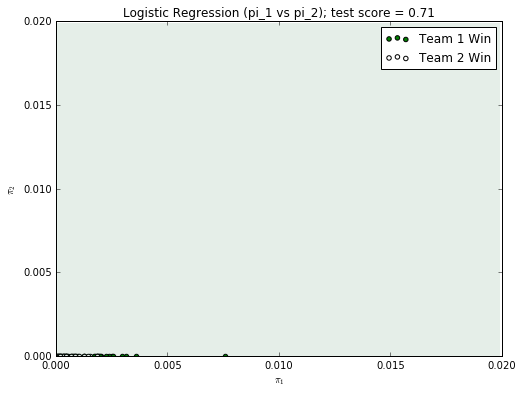

In [181]:
model = LogReg(C=1000000)
model.fit(train_X,train_y)
score = model.score(cross_X, cross_y)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_xlim(0, .02)
ax.set_ylim(0, .02)

print score
plot_decision_boundary(train_X.values, train_y.values, model, "Logistic Regression (pi_1 vs pi_2); test score = {}".format(round(score,2)), ax, bounds=(0, .02), poly_flag=False)

0.700251889169


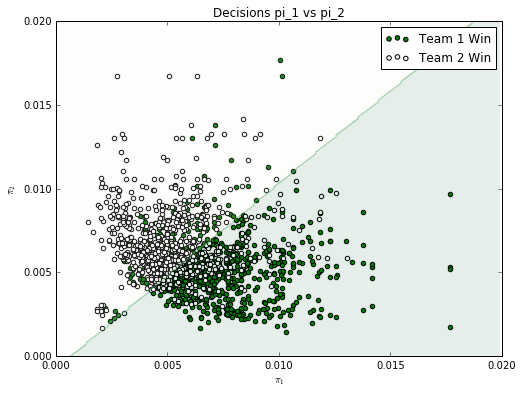

In [139]:
model2 = LDA()
model2.fit(train_X,train_y)
print model2.score(cross_X, cross_y)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_xlim(0, .02)
ax.set_ylim(0, .02)

plot_decision_boundary(train_X.values, train_y.values, model2, "Decisions pi_1 vs pi_2", ax, bounds=(0, .02), poly_flag=False)

In [138]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [ ]:
model2 = LDA()
model2.fit(train_X,train_y)
print model2.score(cross_X, cross_y)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_xlim(0, .02)
ax.set_ylim(0, .02)

plot_decision_boundary(train_X.values, train_y.values, model2, "Decisions pi_1 vs pi_2", ax, bounds=(0, .02), poly_flag=False)

0.695214105793


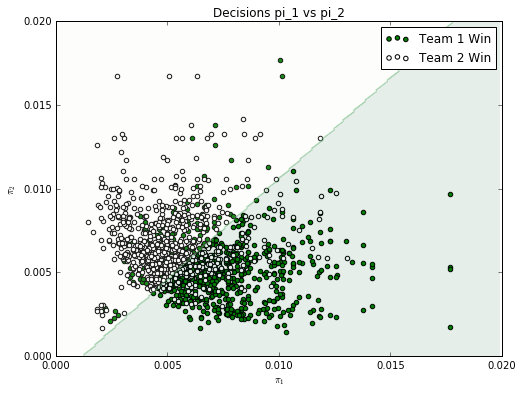

In [142]:
model3 = SVC(C=1000)
model3.fit(train_X,train_y)
print model3.score(cross_X, cross_y)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_xlim(0, .02)
ax.set_ylim(0, .02)

plot_decision_boundary(train_X.values, train_y.values, model3, "Decisions pi_1 vs pi_2", ax, bounds=(0, .02), poly_flag=False)